In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
train_data = pd.read_csv('data/train_values.csv', index_col=0, parse_dates=['timestamp'])
train_labels = pd.read_csv('data/train_labels.csv', index_col=0)
test_data = pd.read_csv('data/test_values.csv', index_col=0, parse_dates=['timestamp'])


**Для начала воспользуемся бэнчмарком, данным на соревновании и попытаемся его улучшить:**

*Пропусков в данных практически нет(кроме последнего столбца)*

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5987820 entries, 0 to 5987819
Data columns (total 35 columns):
process_id                    int64
object_id                     int64
phase                         object
timestamp                     datetime64[ns]
pipeline                      object
supply_flow                   float64
supply_pressure               float64
return_temperature            float64
return_conductivity           float64
return_turbidity              float64
return_flow                   float64
supply_pump                   bool
supply_pre_rinse              bool
supply_caustic                bool
return_caustic                bool
supply_acid                   bool
return_acid                   bool
supply_clean_water            bool
return_recovery_water         bool
return_drain                  bool
object_low_level              bool
tank_level_pre_rinse          float64
tank_level_caustic            float64
tank_level_acid               float64
tank

In [3]:
# subset to final rinse phase observations
#train_data.fillna(value=True, inplace=True)
final_phases = train_data[train_data['target_time_period']]
#just one process
final_phase = final_phases[final_phases['process_id'] == 20017]

In [4]:
# calculate target variable
final_phase = final_phase.assign(target=np.maximum(final_phase['return_flow'], 0) * final_phase['return_turbidity'])

In [5]:
final_phase.head()

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period,target
row_id,,,,,,,,,,,,,,,,,,,,,
13835,20017,204,final_rinse,2018-03-05 21:31:35,L2,8926.505,1.439019,53.754340,9.294569,0.383391,...,82.219330,72.276474,45.519928,45.603252,False,0.0,False,0.0,True,1454.634597
13836,20017,204,final_rinse,2018-03-05 21:31:37,L2,9009.693,1.465712,50.857204,8.735830,0.372540,...,82.219330,72.276474,45.518127,45.603252,False,0.0,False,0.0,True,1499.701905
13837,20017,204,final_rinse,2018-03-05 21:31:39,L2,9165.221,1.516927,48.470055,7.943024,0.368924,...,82.197624,72.276474,45.516660,45.603252,False,0.0,False,0.0,True,1682.626857
13838,20017,204,final_rinse,2018-03-05 21:31:41,L2,9252.025,1.560113,45.988860,7.108860,0.372540,...,82.197624,72.276474,45.514927,45.603252,False,0.0,False,0.0,True,1680.258986
13839,20017,204,final_rinse,2018-03-05 21:31:43,L2,9450.955,1.610677,43.645110,6.823575,0.354456,...,82.219330,72.276474,45.516262,45.603252,False,0.0,False,0.0,True,1553.821926


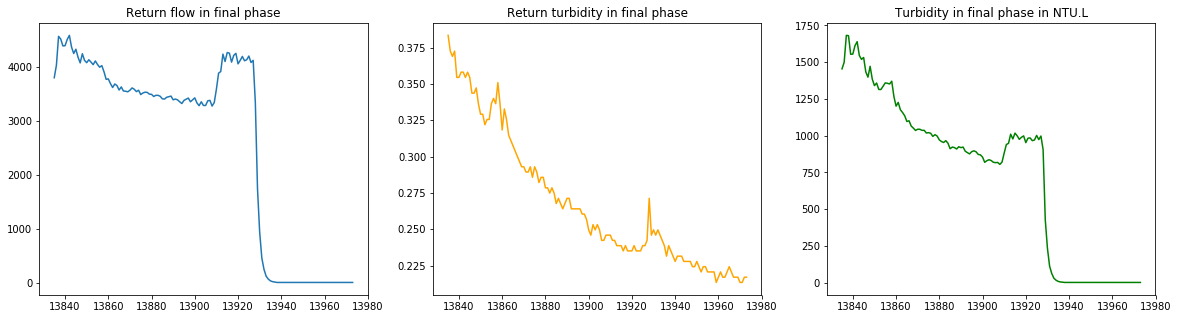

In [6]:
# plot flow, turbidity, and target 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].plot(final_phase['return_flow'])
ax[0].set_title('Return flow in final phase')

ax[1].plot(final_phase['return_turbidity'], c='orange')
ax[1].set_title('Return turbidity in final phase')

ax[2].plot(final_phase['target'], c='green')
ax[2].set_title('Turbidity in final phase in NTU.L');

In [7]:
#sum to get target
final_phase['target'].sum()

103724.28729467509

In [8]:
#confirm that value matches the target label for this process_id
train_labels.loc[20017]

final_rinse_total_turbidity_liter    103724.287295
Name: 20017, dtype: float64

Text(0.5, 1.0, 'Количество процессов в $N$-й фазе')

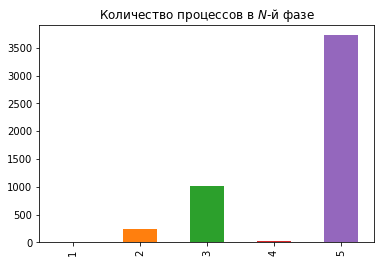

In [10]:
train_data.groupby('process_id')['phase'].nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов в $N$-й фазе")

### Создадим уникальный индентификатор фазы для каждого процесса:


In [11]:
train_data['process_phase'] = train_data.process_id.astype(str) + '_' + train_data.phase.astype(str)
process_phases = train_data.process_phase.unique()

# randomly select 85% of phases to keep
rng = np.random.RandomState(2019)
to_keep = rng.choice(
                process_phases,
                size=np.int(len(process_phases) * 0.85),
                replace=False)

train_limited = train_data[train_data.process_phase.isin(to_keep)]

# subset labels to match our training data
train_labels = train_labels.loc[train_limited.process_id.unique()]

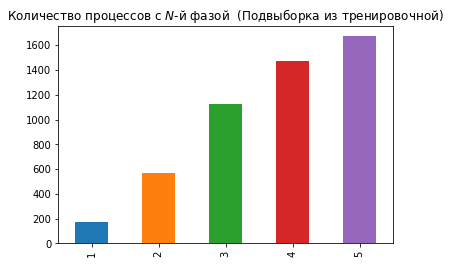

In [12]:
train_limited.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов с $N$-й фазой  (Подвыборка из тренировочной)");

### Feature engineering

In [13]:
def prep_metadata(df):
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data
    if 'L12' not in meta.columns:
        meta['pipeline_L12'] = 0
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# show example for first 5,000 observations
prep_metadata(train_limited.head(5000))

,pipeline_L3,pipeline_L4,pipeline_L7,pipeline_L12,num_phases
process_id,,,,,
20001,0,1,0,0,5
20002,1,0,0,0,2
20003,1,0,0,0,4
20004,0,0,1,0,4
20005,0,0,1,0,1


In [14]:
# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

In [15]:
 import scipy as sc
def prep_time_series_features(df, columns=None):
    if columns is None:
        columns = df.columns
    
    ts_df = df[ts_cols].set_index('process_id')
    
    # create features: min, max, mean, standard deviation, and mean of the last ten observations
    ts_features = ts_df.groupby('process_id').aggregate(['min', 'max', 'mean', 'std',
                                                         lambda x: x.tail(110).mean(),
                                                         'sum', 'mad'])
                                                         

    return ts_features

# show example for first 5,000 observations
prep_time_series_features(train_limited.head(5000), columns=ts_cols)

supply_flow                                                       \
                    min        max          mean           std      <lambda>   
process_id                                                                     
20001         14.467592  59396.703  48103.304716  14069.823956  35188.999460   
20002          7.233796  33951.820  17058.979612  13900.321649  19899.910685   
20003      -1240.596100  84754.770  27647.962599  11689.746443   7078.236811   
20004        -43.402780  49537.035  28037.061740  15469.554587   1938.394319   
20005          0.000000  31116.176  21662.256052  10896.016096  21662.256052   

                                       supply_pressure                      \
                     sum           mad             min       max      mean   
process_id                                                                   
20001       7.850459e+07  10400.247054       -0.036024  2.223741  1.650960   
20002       3.070616e+06  13362.319444       -0.034071  1.863715  1.050162   
20003       5.825426e+07   9382.523219       -0.034071  3.859375  2.466404   
20004       2.828940e+07  12516.479125       -0.009549  0.482422  0.258848   
20005       1.559682e+06   9557.005881       -0.023438  0.487196  0.299428   

              ...    tank_concentration_caustic                          \
              ...                      <lambda>           sum       mad   
process_id    ...                                                         
20001         ...                     45.527483  73951.575370  0.256465   
20002         ...                     45.313808   8169.229960  0.172684   
20003         ...                     44.487910  95016.038589  0.308074   
20004         ...                     45.430164  45776.207534  0.249632   
20005         ...                     44.715849   3219.541139  0.082003   

           tank_concentration_acid                                             \
                               min        max       mean       std   <lambda>   
process_id                                                                      
20001                    39.447857  52.411568  44.704166  0.606253  44.653038   
20002                    44.185707  46.285015  44.765346  0.691738  45.066195   
20003                    41.835228  46.888943  44.439079  0.466711  43.145574   
20004                    44.154810  45.862520  44.673384  0.367765  44.843282   
20005                    43.605465  44.412254  44.004267  0.273263  44.004267   

                                    
                     sum       mad  
process_id                          
20001       72957.198534  0.323908  
20002        8057.762317  0.603282  
20003       93633.139862  0.250657  
20004       45075.444908  0.322484  
20005        3168.307248  0.238562  

[5 rows x 105 columns]

In [16]:
def create_feature_matrix(df):
    metadata = prep_metadata(df)
    time_series = prep_time_series_features(df)
    
    # join metadata and time series features into a single dataframe
    feature_matrix = pd.concat([metadata, time_series], axis=1)
    
    
    return feature_matrix

In [17]:
train_features = create_feature_matrix(train_limited)

# Строим модели и тестируем их:

**Напишем функцию, которая считает ошибку предсказания. Для того, чтобы её можно было использовать вместе с sklearn воспользуемся sklearn.metrics.make_scorer:**

In [18]:
def mean_abs_percentage_err(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), np.full(np.shape(y_true), 290000)))

from sklearn.metrics import make_scorer
mape_modified_scorer = make_scorer(mean_abs_percentage_err, greater_is_better=False)
    

## Воспользуемся TimeSeriesSplit для проведения кросс-валидации для временных рядом и GridSearchCV, чтобы найти оптимальные параметры для 

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, np.ravel(train_labels),
                                    train_size=0.7, random_state=13)

rf_regressor = RandomForestRegressor(n_estimators=50, random_state=13, n_jobs=-1, max_leaf_nodes=165, 
                                     min_samples_leaf=8, min_samples_split=0.005
#                                     max_depth=23,
#                                    max_leaf_nodes= 100,
#                                     min_samples_leaf = 5,
                                     
      
                                    #max_features=17,
                                   # criterion = 'mse',
                                  
                                    )
rf_param_grid =  {
                  'n_estimators' : [50],
                  'random_state' : [13], 
                  #'n_jobs=-1' : [-1],
                  'max_depth' : [35],
                  'max_features' : [40, 50, 80],
                  'min_weight_fraction_leaf' : [0.5, 0.1, 0.01, 0.0001,  0.00001],
                  'min_impurity_decrease' : [0.00001, 0.001, 0.01, 0.1, 1],
                  'min_impurity_split' : [0.00001, 0.001, 0.01, 0.1, 0.5]
                 # 'min_samples_leaf' : list(np.arange(2, 13)) + [20, 25, 50],
                 # 'max_leaf_nodes' : list(np.arange(2, 13)) + [20, 25, 50]
                                        }                 
rf_grid = GridSearchCV(estimator=rf_regressor, cv=TimeSeriesSplit(5), verbose=2,
                       scoring=mape_modified_scorer, n_jobs=-1, param_grid=rf_param_grid)

#sgd_regr = SGDRegressor(penalty='elasticnet', penalty='l1')

In [357]:
#rf_grid.fit(X_train, y_train)

## Оптимальные параметры и лучший результат:

In [358]:
#rf_grid.best_params_, rf_grid.best_score_
#
#({'max_depth': 35,
#  'max_features': 40,
#  'min_impurity_decrease': 0.001,
#  'min_impurity_split': 0.001,
#  'min_weight_fraction_leaf': 0.0001,
#  'n_estimators': 50,
#  'random_state': 13},
# -0.6484711766257679)

In [43]:
#rf_grid.best_params_, rf_grid.best_score_
#({'max_depth': 20,
#  'max_features': 40,
#  'min_samples_leaf': 5,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6180501020995538)
#{'max_depth': 20,
#  'max_features': 50,
#  'max_leaf_nodes': 50,
#  'min_samples_leaf': 3,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6628379946829989

rf_after_grid = RandomForestRegressor(n_estimators=250, max_depth=35, max_features=100, 
                                      min_samples_leaf=8, max_leaf_nodes = 200, min_samples_split=0.005,
                                      min_weight_fraction_leaf = 0.0001,
                                      min_impurity_decrease = 0.001,
                                      bootstrap=False,
                                      random_state=13)
rf_after_grid.fit(X_train, y_train)
#rf_grid.best_params_, rf_grid.best_score_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features=100, max_leaf_nodes=200,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0001, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [44]:
mean_abs_percentage_err(rf_after_grid.predict(X_test), y_test) - 0.522239637086989

0.009414786346846005

## Напишем функцию, которая тестирует модели на кросс-валидации и отложенной выборке

In [45]:
from sklearn.model_selection import cross_val_score
def models_validation(X, y, models, folds):
    tsCV = TimeSeriesSplit(5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 13)
    i = 0
    for model in models:
        i = i + 1
        model.fit(X_train, y_train)
        print(i, 'model cross-val:', np.mean(cross_val_score(model, X, y, scoring=mape_modified_scorer, n_jobs=-1)))
        print(i, 'model on hold data:', mean_abs_percentage_err(model.predict(X_test), y_test))
        print('\n')
    return 0
    
        

In [46]:
models_validation(train_features, np.ravel(train_labels), [rf_after_grid], folds=5)

1 model cross-val: -0.3863346334068305
1 model on hold data: 0.531654423433835




0

In [47]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
extra_tree = ExtraTreesRegressor(criterion='mse', n_estimators=200, max_depth=45, max_features=70, 
                                      min_samples_leaf=5, #min_samples_split=0.005,
                                      #min_weight_fraction_leaf = 0.0001,
                                      #min_impurity_decrease = 0.001,
                                      bootstrap=False,
                                      random_state=13)
bagging = BaggingRegressor(max_samples=0.85, n_estimators=10, )
svr = SVR(C=0.01, epsilon=1, kernel='sigmoid', coef0=1, max_iter=1000)
rdg = Ridge()
lss = Lasso()
els = ElasticNet(copy_X=True)

In [48]:
models_validation(train_features, np.ravel(train_labels), [extra_tree, bagging, svr, rdg, lss, els], folds=5)

1 model cross-val: -0.36926322584398014
1 model on hold data: 0.5834394514334852


2 model cross-val: -0.39766766179525354
2 model on hold data: 0.6356260779238188


3 model cross-val: -1.9357838416141087
3 model on hold data: 1.2796595374376702


4 model cross-val: -1.0659279480750794
4 model on hold data: 2.6599163687550664


5 model cross-val: -1.0817484241453887
5 model on hold data: 2.667556553853688


6 model cross-val: -0.9633636489029488
6 model on hold data: 2.233628665929417




0

In [49]:
rf_after_grid.fit(train_features, np.ravel(train_labels))

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features=100, max_leaf_nodes=200,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0001, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [50]:
test_features = create_feature_matrix(test_data)


In [51]:
preds = rf_after_grid.predict(test_features)

In [52]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [53]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [54]:
my_submission.to_csv('./submissions/6th_try_to_beat_benchmark.csv')

In [41]:
rf_after_grid.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features=50, max_leaf_nodes=165, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=0.005, min_weight_fraction_leaf=0.0,
           n_estimators=275, n_jobs=None, oob_score=False, random_state=13,
           verbose=0, warm_start=False)

In [79]:
mape_modified_scorer(rf_after_grid, X_test, y_test), mean_abs_percentage_err(rf_after_grid.predict(X_test), y_test)

(-0.549157172260939, 0.9148239861830831)

In [89]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
ridge_param_grid = {'alpha' : [1.001, 20000, 0.00000001, 0.00001, 0.00004, 0.5, 0.8, 0.9],
                    'tol' : list(0.1 + np.arange(50) / 5000) + [1, 2, 5, 10]}
ridge = Ridge(normalize=True, fit_intercept=True, max_iter=500 )
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, cv=TimeSeriesSplit(5), 
                         verbose=1, scoring=mape_modified_scorer)
ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed:   12.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=500,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1.001, 20000, 1e-08, 1e-05, 4e-05, 0.5, 0.8, 0.9], 'tol': [0.1, 0.10020000000000001, 0.1004, 0.10060000000000001, 0.1008, 0.101, 0.10120000000000001, 0.1014, 0.10160000000000001, 0.1018, 0.10200000000000001, 0.1022, 0.1024, 0.10260000000000001, 0.1028, 0.10300000000000001, 0.10... 0.10880000000000001, 0.109, 0.1092, 0.10940000000000001, 0.1096, 0.10980000000000001, 1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
       verbose=1)

In [90]:
ridge_grid.best_params_

{'alpha': 1.001, 'tol': 0.1}

In [91]:
mape_modified_scorer(ridge_grid, X_test, y_test), mean_abs_percentage_err(ridge_grid.predict(X_test), y_test)

(-0.8668668309153095, 2.147872467088798)

In [56]:
preds = sgd.predict(test_features)

In [57]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [58]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [59]:
my_submission.to_csv('./submissions/4th_try_to_beat_benchmark.csv')

In [65]:
subm_1 = pd.read_csv('./submissions/third_try_to_beat_benchmark.csv', index_col=0)
subm_2 = pd.read_csv('./submissions/4th_try_to_beat_benchmark.csv', index_col=0)
np.mean(subm_1['final_rinse_total_turbidity_liter'] - subm_2['final_rinse_total_turbidity_liter'])

92212.39571947652

74322.23702776793